In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

media = [
    'Monitor',
    'frontal', 
    'Maischberger', 
    'Tagesthemen',
    'maybrit illner', 
    'Markus Lanz', 
    'Frontal 21', 
    'Hart aber fair',
    'Anne Will',
]

search_terms = {
    'cdu':['cdu', 'union'],
    'csu':['csu', 'union'],
    'fdp':['fdp', 'freien demokraten'],
    'grüne':['grünen'],
    'linke':['linke', 'linkspartei'],
    'afd':['afd', 'afg'],
    'spd':['spd', 'sozialdemokraten'],
}

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [13]:
def extract_party_mentions(input_string, party_strings, n_words=10):
    input_string = input_string.lower()
    party_boolean = [False for i in input_string.split()]
    for p in party_strings:
        temp = [string.__contains__(p) for string in input_string.split()]
        party_boolean = [party_boolean|temp for (party_boolean,temp) in zip(party_boolean, temp)]
    party_index = np.where(party_boolean)[0]
    output_strings = ['' for _ in range(len(party_index))]
    for i in range(len(party_index)):
        lower_bound = party_index[i]-n_words
        upper_bound = party_index[i]+n_words
        if lower_bound < 0:
            lower_bound = 0
        if upper_bound > len(input_string.split()):
            upper_bound = len(input_string.split())
        output_strings[i] = " ".join(input_string.split()[lower_bound:upper_bound])
    return output_strings

def extract_mention_df(party):
    subset = 'contains_' + party
    res_series = df['transcript'].loc[df[subset]].parallel_apply(lambda transcript: extract_party_mentions(input_string=transcript, party_strings=search_terms[party], n_words=10))
    temp = {'medium': df['medium'].loc[df[subset]], 'transcript':res_series}
    res_df = pd.DataFrame(temp).explode(column='transcript')
    res_df.reset_index(inplace=True)
    res_df.dropna(inplace=True)
    res_df.drop(res_df.index[res_df['transcript'] == ''], inplace=True)
    return res_df

def extract_sentiment_df(input_df):
    input_df['sentiment'] = input_df['transcript'].progress_apply(classifier)
    input_df['positive'] = [True if sent[0]['label']=='positive' else False for sent in input_df['sentiment']]
    input_df['neutral'] = [True if sent[0]['label']=='neutral' else False for sent in input_df['sentiment']]
    input_df['negative'] = [True if sent[0]['label']=='negative' else False for sent in input_df['sentiment']]
    input_df['score'] = [sent[0]['score'] for sent in input_df['sentiment']]
    return input_df

def extract_sentiment_counts_df(input_df):
    count_pos = input_df[input_df['positive']].groupby(['medium'])['positive'].sum()
    count_neu = input_df[input_df['neutral']].groupby(['medium'])['neutral'].sum()
    count_neg = input_df[input_df['negative']].groupby(['medium'])['negative'].sum()
    output_df = pd.DataFrame(data={'count_pos':count_pos, 'count_neu':count_neu, 'count_neg':count_neg})
    return output_df

def get_party_sentiment_counts(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_sentiment_counts_df(df)
    return df['count_pos'], df['count_neu'], df['count_neg']

def standardize_df(input_df):
    df = input_df.copy()
    for party in search_terms.keys():
        df[party] -= df[party].mean()
    return df.round(3)

In [14]:
skip_computation = True

df = pd.read_pickle('../data/mediathek_data.pkl')
df['medium'] = df['id']
for party in search_terms.keys():
    df['contains_'+party] = [False for _ in range(len(df.index))]
    for term in search_terms[party]:
        df['contains_'+party] = df['contains_'+party] | df['preprocessed'].str.contains(term)

tokenizer = AutoTokenizer.from_pretrained("mdraw/german-news-sentiment-bert")
model = AutoModelForSequenceClassification.from_pretrained("mdraw/german-news-sentiment-bert")
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
scaler = StandardScaler()

In [15]:
if skip_computation:
    pos_counts_df = pd.read_pickle('../data/sentiment/pos_counts_mediathek_df.pkl')
    neu_counts_df = pd.read_pickle('../data/sentiment/neu_counts_mediathek_df.pkl')
    neg_counts_df = pd.read_pickle('../data/sentiment/neg_counts_mediathek_df.pkl')
else:
    pos_counts_dict = {}
    neu_counts_dict = {}
    neg_counts_dict = {}
    for party in search_terms.keys():
        pos_counts_dict[party], neu_counts_dict[party], neg_counts_dict[party] = get_party_sentiment_counts(party)

    pos_counts_df = pd.DataFrame(pos_counts_dict)
    pos_counts_df = pos_counts_df.loc[media]
    pos_counts_df = pos_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neu_counts_df = pd.DataFrame(neu_counts_dict)
    neu_counts_df = neu_counts_df.loc[media]
    neu_counts_df = neu_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neg_counts_df = pd.DataFrame(neg_counts_dict)
    neg_counts_df = neg_counts_df.loc[media]
    neg_counts_df = neg_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]

    pos_counts_df.to_pickle('../data/sentiment/pos_counts_mediathek_df.pkl')
    neu_counts_df.to_pickle('../data/sentiment/neu_counts_mediathek_df.pkl')
    neg_counts_df.to_pickle('../data/sentiment/neg_counts_mediathek_df.pkl')

[Text(0.5, 51.0, 'party'),
 Text(60.0, 0.5, 'medium'),
 Text(0.5, 1.0, 'positive sentiment proportions by medium and party, standardized')]

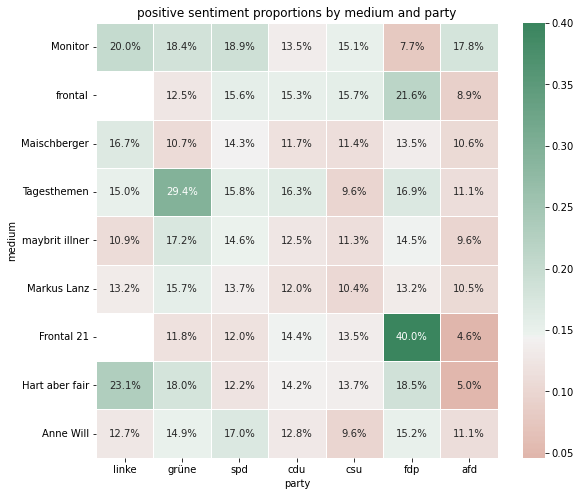

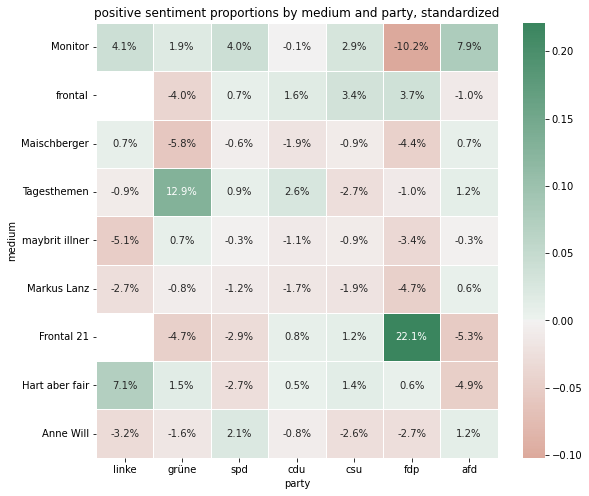

In [16]:
pos = pos_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        pos.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(pos, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(pos), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(pos), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(pos)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party, standardized')

In [17]:
print(f"positive sentiment means:\n{pos.mean()}\n\npositive sentiment standard deviation:\n{pos.std()}")

positive sentiment means:
linke    0.159344
grüne    0.164946
spd      0.148847
cdu      0.136476
csu      0.122473
fdp      0.178803
afd      0.099140
dtype: float64

positive sentiment standard deviation:
linke    0.043281
grüne    0.055729
spd      0.022142
cdu      0.015312
csu      0.023088
fdp      0.091393
afd      0.038577
dtype: float64


[Text(0.5, 51.0, 'party'),
 Text(60.0, 0.5, 'medium'),
 Text(0.5, 1.0, 'neutral sentiment proportions by medium and party, standardized')]

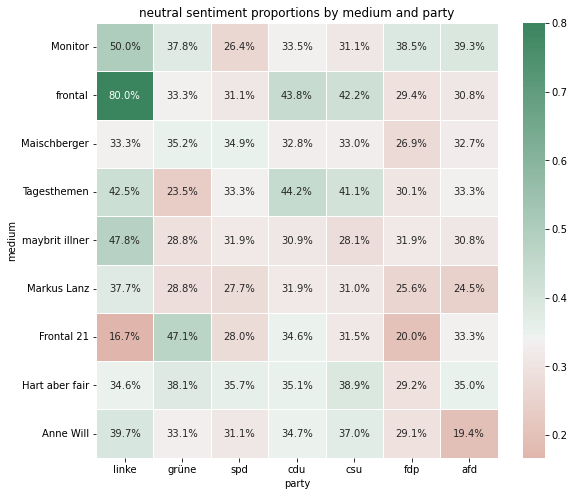

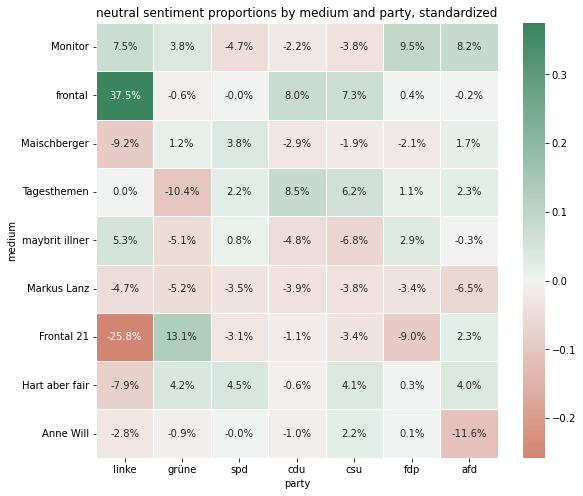

In [18]:
neu = neu_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neu.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neu, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neu), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neu), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neu)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party, standardized')

In [19]:
print(f"neutral sentiment means:\n{neu.mean()}\n\nneutral sentiment standard deviation:\n{neu.std()}")

neutral sentiment means:
linke    0.424852
grüne    0.339710
spd      0.311223
cdu      0.357230
csu      0.348686
fdp      0.289788
afd      0.310200
dtype: float64

neutral sentiment standard deviation:
linke    0.170843
grüne    0.067830
spd      0.032470
cdu      0.048753
csu      0.050507
fdp      0.049538
afd      0.058558
dtype: float64


[Text(0.5, 51.0, 'party'),
 Text(60.0, 0.5, 'medium'),
 Text(0.5, 1.0, 'negative sentiment proportions by medium and party, standardized')]

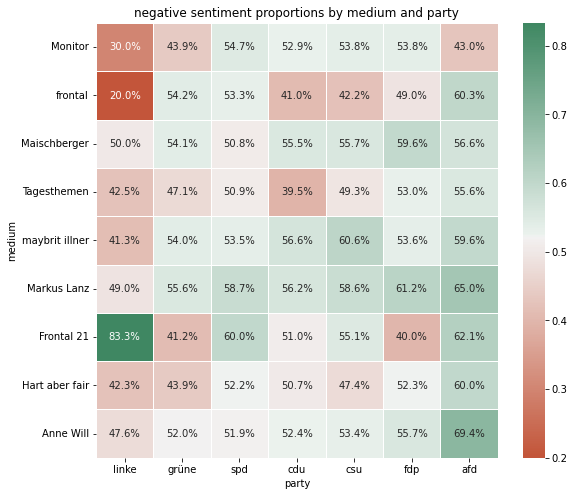

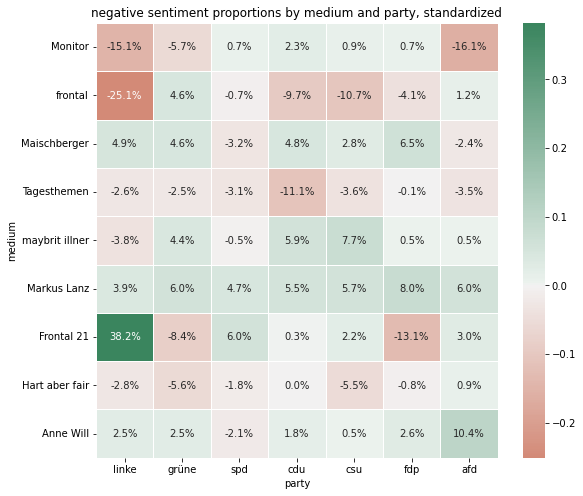

In [20]:
neg = neg_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neg.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neg, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neg), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neg), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neg)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party, standardized')

In [21]:
print(f"negative sentiment means:\n{neg.mean()}\n\nnegative sentiment standard deviation:\n{neg.std()}")

negative sentiment means:
linke    0.451213
grüne    0.495345
spd      0.539930
cdu      0.506294
csu      0.528840
fdp      0.531410
afd      0.590659
dtype: float64

negative sentiment standard deviation:
linke    0.173008
grüne    0.055267
spd      0.032946
cdu      0.062653
csu      0.057459
fdp      0.061625
afd      0.073529
dtype: float64
